In [33]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
from experiments.exp_basic import Exp_Basic
from experiments.exp_long_term_forecasting_partial import Exp_Long_Term_Forecast_Partial
from experiments.exp_long_term_forecasting import Exp_Long_Term_Forecast
from data_provider.data_factory import data_provider
import random
import torch
import sys
import os

sys.argv = ['']

fix_seed = 2023
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)

In [34]:
    parser = argparse.ArgumentParser(description='iTransformer')

    # basic config
    parser.add_argument('--is_training', type=int, required=False, default=1, help='status')
    parser.add_argument('--model_id', type=str, required=False, default='Exchange_96_96', help='model id')
    parser.add_argument('--model', type=str, required=False, default='iTransformer',
                        help='model name, options: [iTransformer, iInformer, iReformer, iFlowformer, iFlashformer]')

    # data loader
    parser.add_argument('--data', type=str, required=False, default='custom', help='dataset type')
    parser.add_argument('--root_path', type=str, default='C:/Users/Admin/Desktop/DSP/', help='root path of the data file')
    parser.add_argument('--data_path', type=str, default='df_combine.csv', help='data csv file')
    parser.add_argument('--features', type=str, default='S',
                        help='forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate')
    parser.add_argument('--target', type=str, default='SELL', help='target feature in S or MS task')
    parser.add_argument('--freq', type=str, default='h',
                        help='freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h')
    parser.add_argument('--checkpoints', type=str, default='./checkpoints/', help='location of model checkpoints')

    # forecasting task
    parser.add_argument('--seq_len', type=int, default=96, help='input sequence length')
    parser.add_argument('--label_len', type=int, default=48, help='start token length') # no longer needed in inverted Transformers
    parser.add_argument('--pred_len', type=int, default=96, help='prediction sequence length')

    # model define
    parser.add_argument('--enc_in', type=int, default=7, help='encoder input size')
    parser.add_argument('--dec_in', type=int, default=7, help='decoder input size')
    parser.add_argument('--c_out', type=int, default=7, help='output size') # applicable on arbitrary number of variates in inverted Transformers
    parser.add_argument('--d_model', type=int, default=128, help='dimension of model')
    parser.add_argument('--n_heads', type=int, default=8, help='num of heads')
    parser.add_argument('--e_layers', type=int, default=2, help='num of encoder layers')
    parser.add_argument('--d_layers', type=int, default=1, help='num of decoder layers')
    parser.add_argument('--d_ff', type=int, default=128, help='dimension of fcn')
    parser.add_argument('--moving_avg', type=int, default=25, help='window size of moving average')
    parser.add_argument('--factor', type=int, default=1, help='attn factor')
    parser.add_argument('--distil', action='store_false',
                        help='whether to use distilling in encoder, using this argument means not using distilling',
                        default=True)
    parser.add_argument('--dropout', type=float, default=0.1, help='dropout')
    parser.add_argument('--embed', type=str, default='timeF',
                        help='time features encoding, options:[timeF, fixed, learned]')
    parser.add_argument('--activation', type=str, default='gelu', help='activation')
    parser.add_argument('--output_attention', action='store_true', help='whether to output attention in ecoder')
    parser.add_argument('--do_predict', action='store_true', help='whether to predict unseen future data')

    # optimization
    parser.add_argument('--num_workers', type=int, default=10, help='data loader num workers')
    parser.add_argument('--itr', type=int, default=1, help='experiments times')
    parser.add_argument('--train_epochs', type=int, default=10, help='train epochs')
    parser.add_argument('--batch_size', type=int, default=32, help='batch size of train input data')
    parser.add_argument('--patience', type=int, default=3, help='early stopping patience')
    parser.add_argument('--learning_rate', type=float, default=0.0001, help='optimizer learning rate')
    parser.add_argument('--des', type=str, default='Exp', help='exp description')
    parser.add_argument('--loss', type=str, default='MSE', help='loss function')
    parser.add_argument('--lradj', type=str, default='type1', help='adjust learning rate')
    parser.add_argument('--use_amp', action='store_true', help='use automatic mixed precision training', default=False)

    # GPU
    parser.add_argument('--use_gpu', type=bool, default=False, help='use gpu')
    parser.add_argument('--gpu', type=int, default=0, help='gpu')
    parser.add_argument('--use_multi_gpu', action='store_true', help='use multiple gpus', default=False)
    parser.add_argument('--devices', type=str, default='0,1,2,3', help='device ids of multile gpus')

    # iTransformer
    parser.add_argument('--exp_name', type=str, required=False, default='partial_train',
                        help='experiemnt name, options:[MTSF, partial_train]')
    parser.add_argument('--channel_independence', type=bool, default=False, help='whether to use channel_independence mechanism')
    parser.add_argument('--inverse', action='store_true', help='inverse output data', default=False)
    parser.add_argument('--class_strategy', type=str, default='projection', help='projection/average/cls_token')
    parser.add_argument('--target_root_path', type=str, default='C:/Users/Admin/Desktop/DSP/', help='root path of the data file')
    parser.add_argument('--target_data_path', type=str, default='df_combine.csv', help='data file')
    parser.add_argument('--efficient_training', type=bool, default=False, help='whether to use efficient_training (exp_name should be partial train)') # See Figure 8 of our paper for the detail
    parser.add_argument('--use_norm', type=int, default=True, help='use norm and denorm')
    parser.add_argument('--partial_start_index', type=int, default=0, help='the start index of variates for partial training, '
                                                                           'you can select [partial_start_index, min(enc_in + partial_start_index, N)]')
    args = parser.parse_args()


In [35]:
setting = '{}_{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_eb{}_dt{}_{}_{}'.format(
            args.model_id,
            args.model,
            args.data,
            args.features,
            args.seq_len,
            args.label_len,
            args.pred_len,
            args.d_model,
            args.n_heads,
            args.e_layers,
            args.d_layers,
            args.d_ff,
            args.factor,
            args.embed,
            args.distil,
            args.des,
            args.class_strategy, 0)
setting

'Exchange_96_96_iTransformer_custom_S_ft96_sl48_ll96_pl128_dm8_nh2_el1_dl128_df1_fctimeF_ebTrue_dtExp_projection_0'

In [36]:
exp = Exp_Long_Term_Forecast_Partial(args)
exp.model.load_state_dict(torch.load(os.path.join('./checkpoints/' + setting, 'checkpoint.pth')))

Use CPU


<All keys matched successfully>

['Date', 'Buy Cash', 'Buy Transfer', 'Sell', 'inflation_rate_vn', 'inflation_rate_us', 'unemploy_rate_us', 'unemploy_rate_vn', 'fdi_vn', 'fdi_us']
Sell
[[-1.96703237]
 [-1.92100629]
 [-1.92100629]
 ...
 [10.52904952]
 [10.52904952]
 [10.52904952]]
test 371
loading model
test shape: (371, 1, 96, 1) (371, 1, 96, 1)
test shape: (371, 96, 1) (371, 96, 1)
mse:2.7292160987854004, mae:1.259743332862854


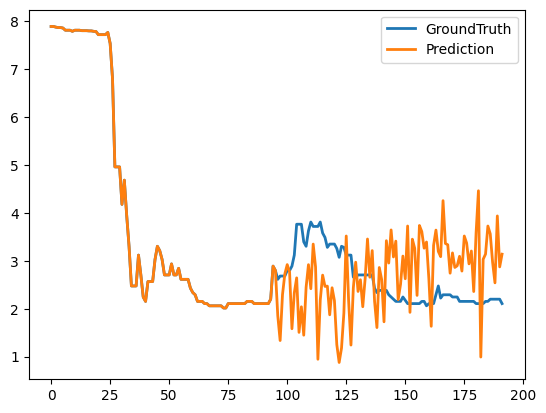

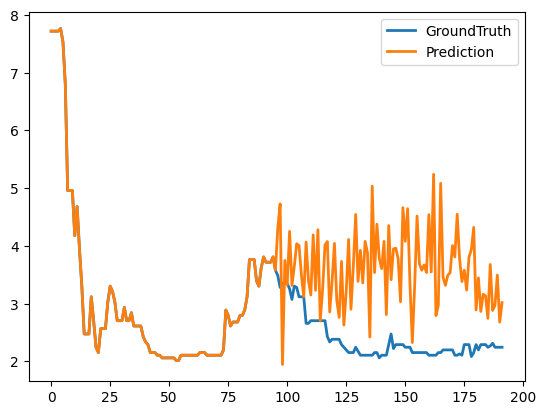

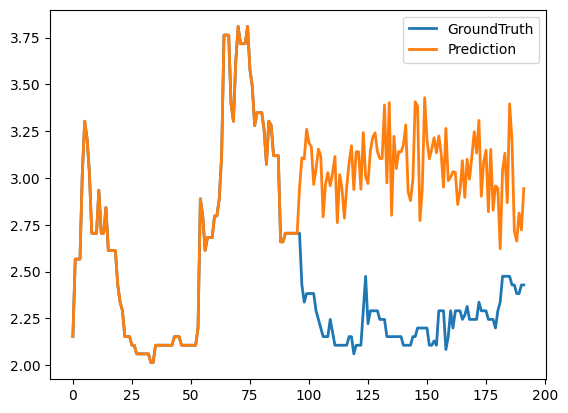

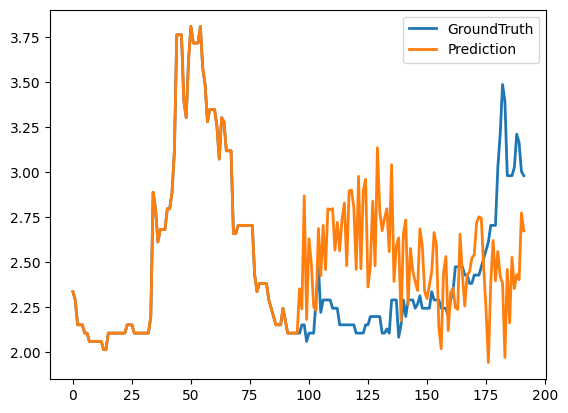

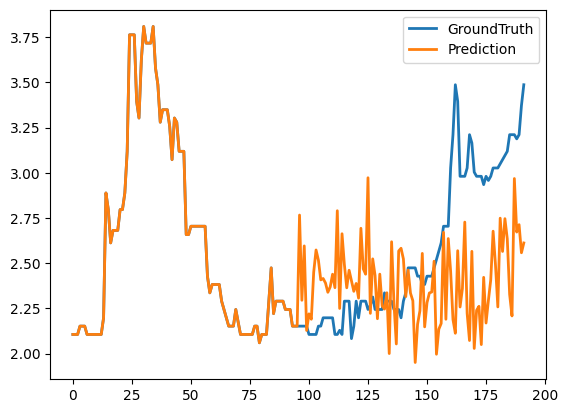

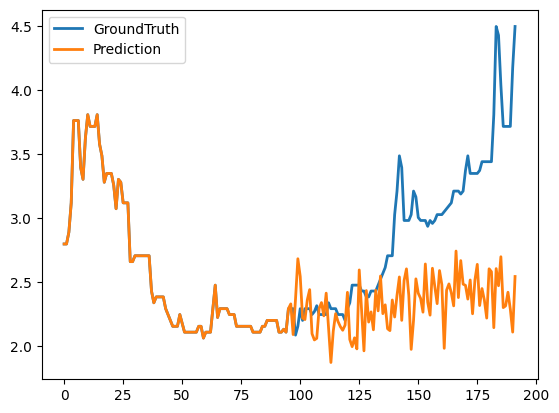

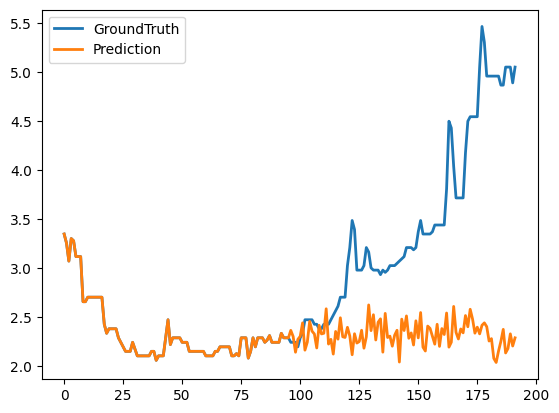

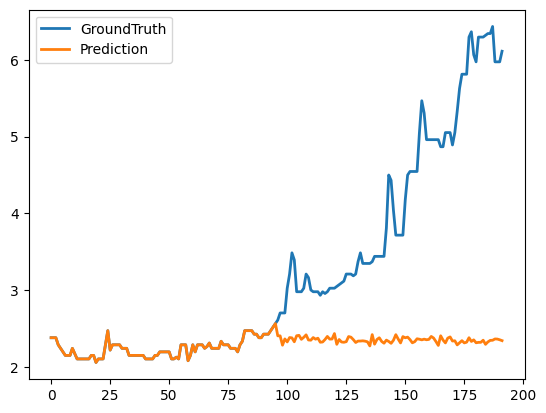

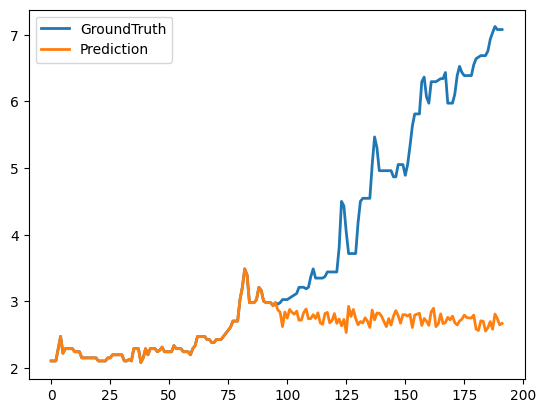

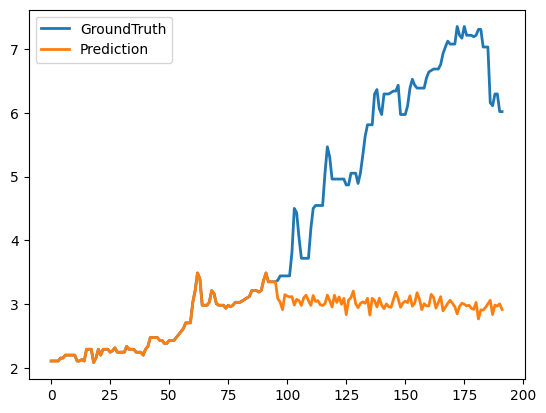

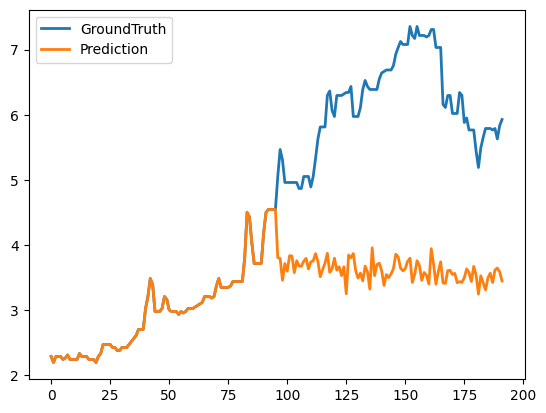

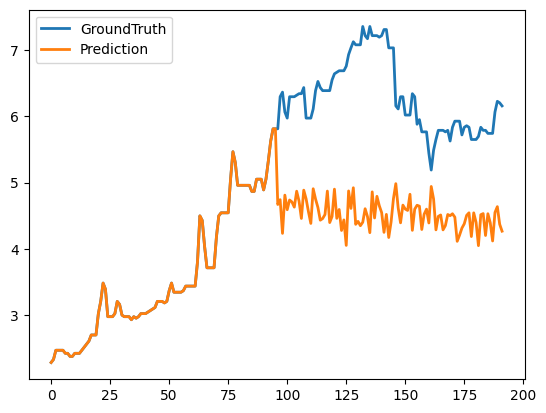

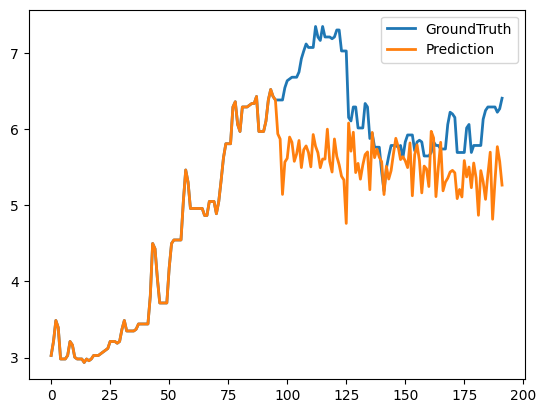

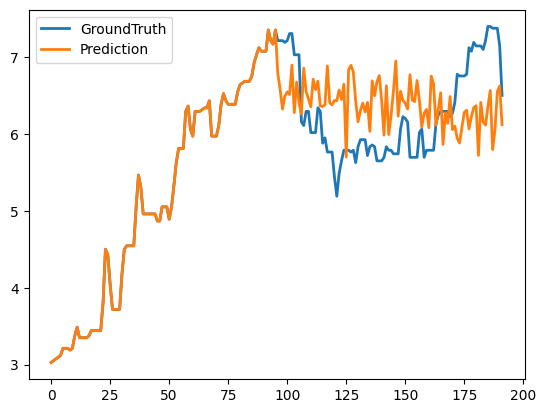

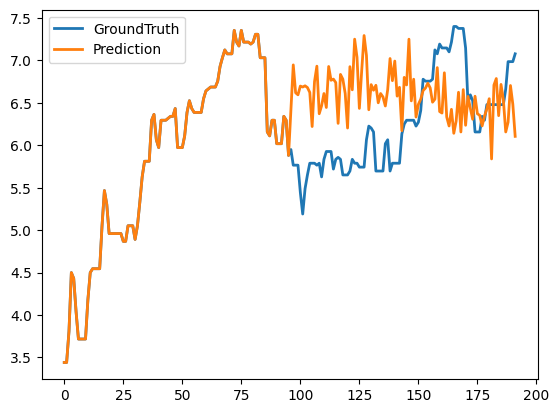

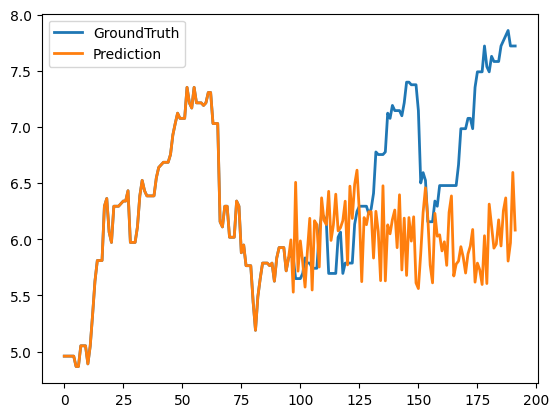

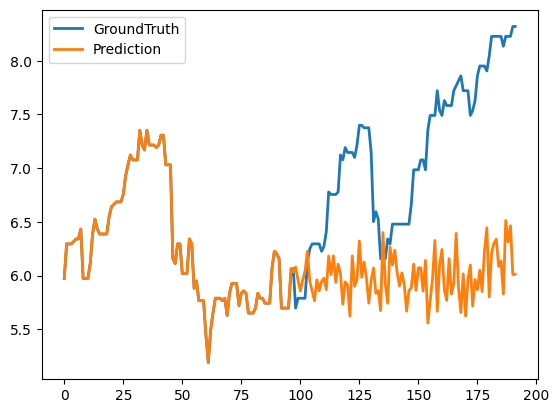

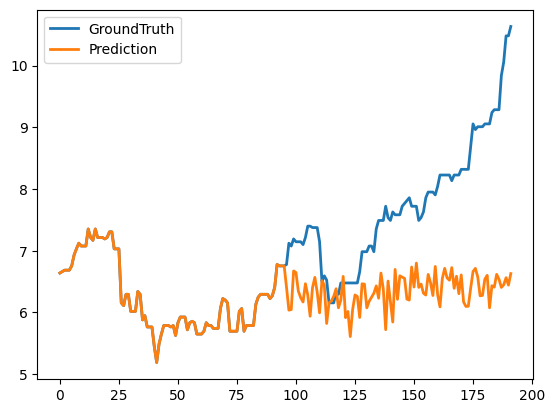

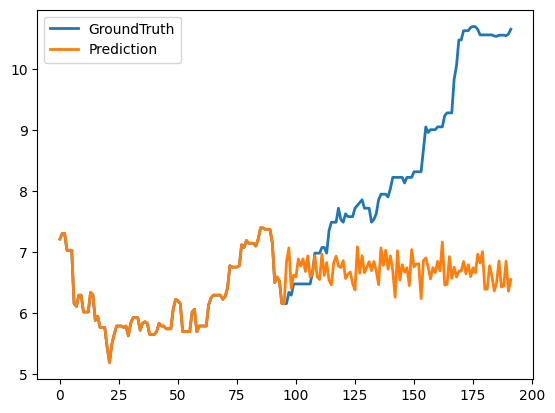

In [53]:
exp.test(setting)

In [54]:
mae, mse, rmse, mape, mspe = np.load(os.path.join('results/' + setting, 'metrics.npy'))
preds = np.load(os.path.join('results/' + setting, 'pred.npy'))
trues = np.load(os.path.join('results/' + setting, 'true.npy'))
train_loss = np.load(os.path.join('results/' + setting, 'train_loss.npy'))
val_loss = np.load(os.path.join('results/' + setting, 'val_loss.npy'))

In [55]:
train_loss

array([0.68322264, 0.60529286, 0.57409283, 0.56181302, 0.55694538])

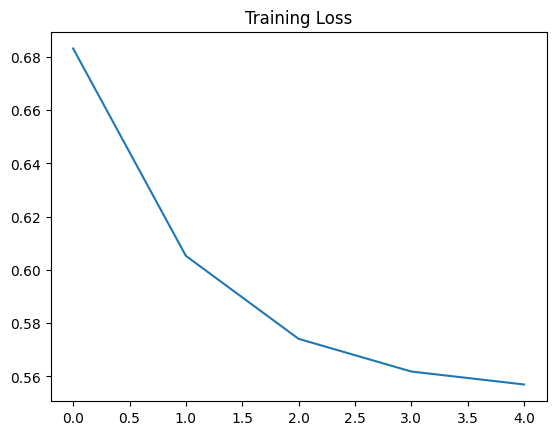

In [56]:
plt.plot(train_loss)

plt.title('Training Loss')
plt.show()

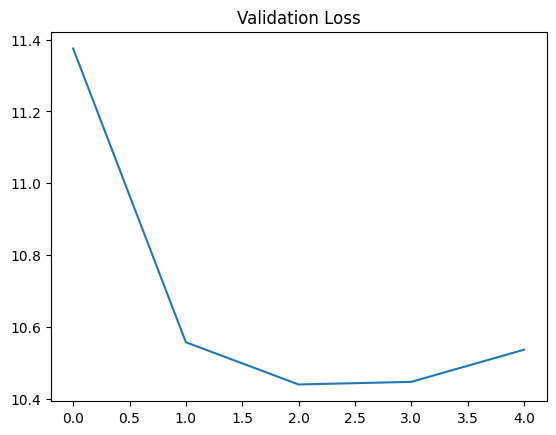

In [57]:
plt.plot(val_loss)

plt.title('Validation Loss')
plt.show()